In [1]:
%load_ext autoreload
%autoreload 2

First, import the necessary libraries.

In [2]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(432)

Display the first 5 rows of the dataset to get an idea of what the csv file looks like.

In [3]:
# Convert csv to dataframe
df = pd.read_csv('speakers_all.csv')

# Display the first 5 rows of the dataframe and see what data is available
df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


Since our goal is to predict whether a person's native english speaker or not, we will primarily be looking at the 'native_language' column. We will also be taking care to not include files that are labeled as being missing data.

In [4]:
english = df[(df['native_language'] == 'english') & (df['file_missing?'] == False)]['filename']
non_english = df[(df['native_language'] != 'english') & (df['file_missing?'] == False)]['filename']

print('Number of english: ', len(english))
print('Number of non-english: ', len(non_english))

# Create a list of countries that have less than 25
native_languages = df['native_language'].value_counts()
native_languages = native_languages[native_languages < 20].index.tolist()

# Remove those countries
df = df[~df['native_language'].isin(native_languages)]

english = df[(df['native_language'] == 'english') & (df['file_missing?'] == False)]['filename']
non_english = df[(df['native_language'] != 'english') & (df['file_missing?'] == False)]['filename']

print("After cleaning up the")
print('Number of english: ', len(english))
print('Number of non-english: ', len(non_english))

Number of english:  579
Number of non-english:  1559
After cleaning up the
Number of english:  579
Number of non-english:  908


Let's import some helper functions to help us visualize some data that we can pull from the dataset.

In [22]:
from AudioAugmentations import *

Let's first explore what the MFC (Mel-Frequency Cepstrum) for a native english speaker looks like and a non-native english speaker looks like.

In [23]:
# Sample a random file name from the english list
english_file = np.random.choice(english)
non_english_file = np.random.choice(non_english)

# Add the path and file extension
english_file = 'recordings/recordings/' + english_file + '.mp3'
non_english_file = 'recordings/recordings/' + non_english_file + '.mp3'

Text(0.5, 1.0, 'MFC of recordings/recordings/spanish152.mp3')

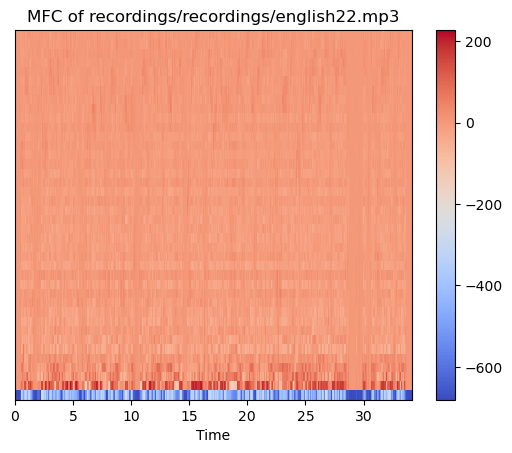

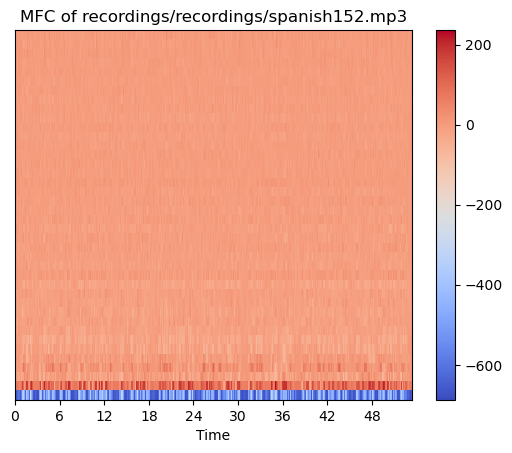

In [24]:
# Calculate the MFC
english_mfc = extract_mfcc(english_file, n_mfcc=40)

# Plot the MFC
plt.figure()
librosa.display.specshow(english_mfc, x_axis='time', n_fft=512, hop_length=256)
plt.colorbar()
plt.title('MFC of ' + english_file)

# Calculate the MFC
non_english_mfc = extract_mfcc(non_english_file, n_mfcc=40)

# Plot the MFC
plt.figure()
librosa.display.specshow(non_english_mfc, x_axis='time', n_fft=512, hop_length=256)
plt.colorbar()
plt.title('MFC of ' + non_english_file)


Text(0.5, 1.0, 'Spectrogram of recordings/recordings/spanish152.mp3')

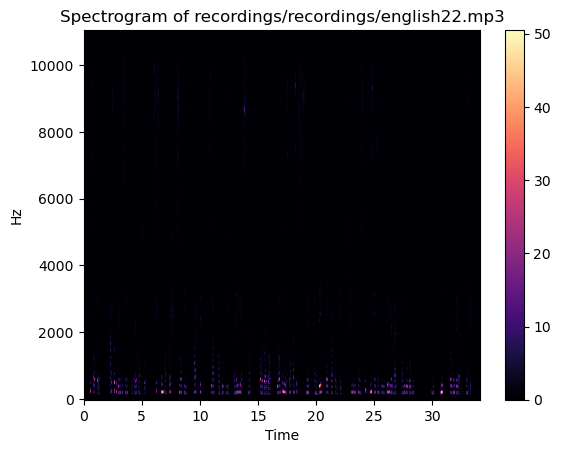

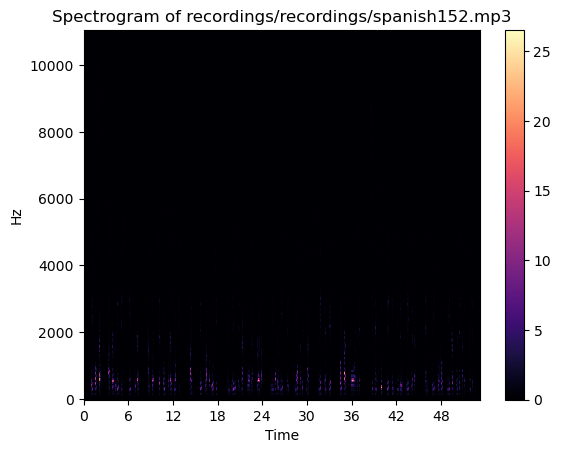

In [25]:

# Calculate the spectrogram for the english file
spectrogram = calculate_spectrogram(english_file)

# Plot the spectrogram
plt.figure()
librosa.display.specshow(spectrogram, sr=22050, n_fft=512, hop_length=256, x_axis='time', y_axis='linear')
plt.colorbar()
plt.title('Spectrogram of ' + english_file)

# Calculate the spectrogram for non-english
spectrogram = calculate_spectrogram(non_english_file)

# Plot the spectrogram
plt.figure()
librosa.display.specshow(spectrogram, sr=22050, n_fft=512, hop_length=256, x_axis='time', y_axis='linear')
plt.colorbar()
plt.title('Spectrogram of ' + non_english_file)



As expected, the energy content for both the native english speaker and non-native english speaker are primarily present at the lower frequencies due to the natural range of the human voice. At this scale, there is also not a lot of contrast for the two different speakers.

Let's try a spectrogram at the mel scale

Text(0.5, 1.0, 'Mel-Spectrogram of recordings/recordings/spanish152.mp3')

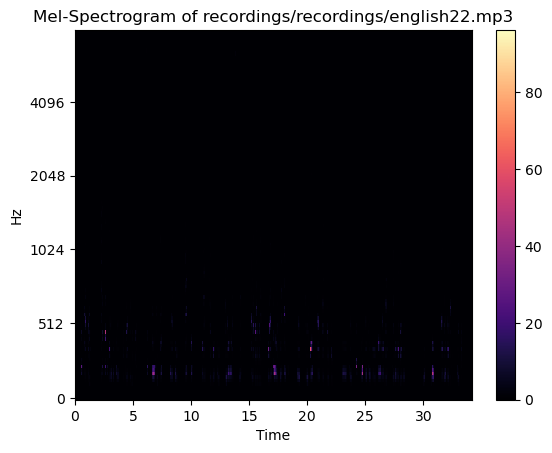

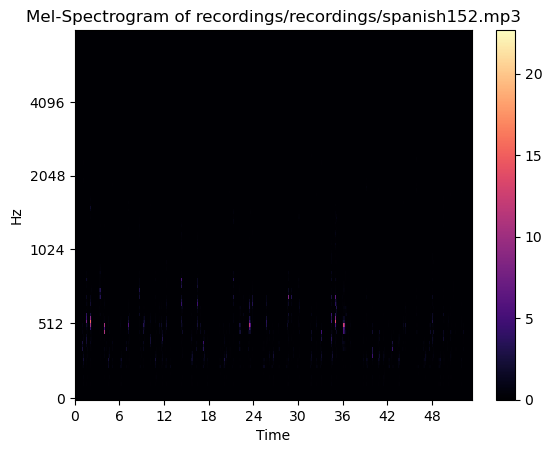

In [26]:

# Calculate the spectrogram for the english file
spectrogram = calculate_mel_spectrogram(english_file)

# Plot the spectrogram
plt.figure()
librosa.display.specshow(spectrogram, sr=22050, n_fft=512, hop_length=256, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar()
plt.title('Mel-Spectrogram of ' + english_file)

# Calculate the spectrogram for non-english
spectrogram = calculate_mel_spectrogram(non_english_file)

# Plot the spectrogram
plt.figure()
librosa.display.specshow(spectrogram, sr=22050, n_fft=512, hop_length=256, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar()
plt.title('Mel-Spectrogram of ' + non_english_file)



Let's now try converting the power spectrogram in decibel units for better visualization.

Text(0.5, 1.0, 'Log Mel-Spectrogram of recordings/recordings/spanish152.mp3')

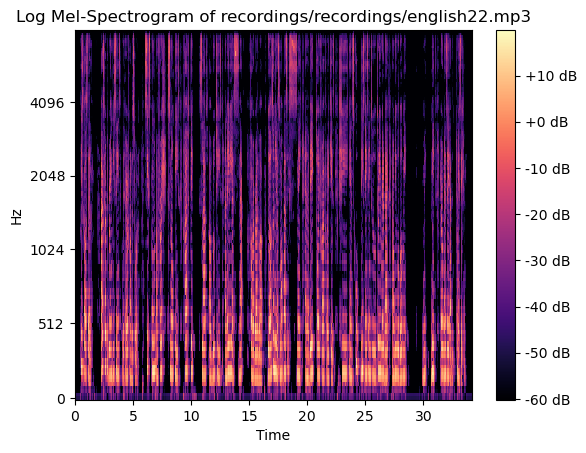

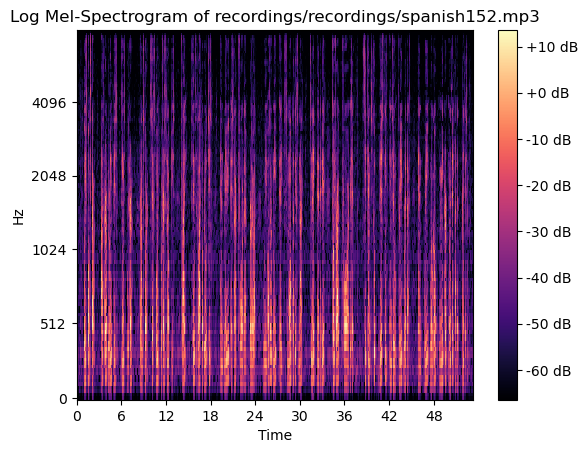

In [27]:

# Calculate the spectrogram for the english file
spectrogram = calculate_log_mel_spectrogram(english_file)

# Plot the spectrogram
plt.figure()
librosa.display.specshow(spectrogram, sr=22050, n_fft=512, hop_length=256, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format="%+2.f dB")
plt.title('Log Mel-Spectrogram of ' + english_file)

# Calculate the spectrogram for non-english
spectrogram = calculate_log_mel_spectrogram(non_english_file)

# Plot the spectrogram
plt.figure()
librosa.display.specshow(spectrogram, sr=22050, n_fft=512, hop_length=256, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format="%+2.f dB")
plt.title('Log Mel-Spectrogram of ' + non_english_file)

